In [1]:
import warnings
warnings.filterwarnings("ignore")
from utils import load_preds, UNIQUE_MODELS, COLOR_MAP

In [2]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [3]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
from epiweeks import Week
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mosqlient.models.score import Scorer
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.cbook as cbook
import seaborn as sns
import matplotlib as mpl
# Definir a cor das bordas (spines) como cinza
mpl.rcParams['axes.edgecolor'] = 'gray'

# Definir a cor das linhas dos ticks maiores e menores como cinza
mpl.rcParams['xtick.color'] = 'gray'
mpl.rcParams['ytick.color'] = 'gray'
mpl.rcParams['xtick.labelcolor'] = 'black'
mpl.rcParams['ytick.labelcolor'] = 'black'

## Figure 4. Error in target quantities (univariate summaries)

* Boxplots com os deltas de semana do pico (por modelo, pontos dentro dos boxplots são os estados)

* Boxplots com o MAPE do pico com uma janela de k=3 semanas

* Boxplots com o MAPE do total de casos na temporada 

In [4]:
dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

data_all = pd.read_csv('../data/dengue_uf.csv.gz')
data_all.date = pd.to_datetime(data_all.date)

In [5]:
states_ne = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'SE', 'RN']
states_se = ['SP', 'RJ', 'ES', 'MG']
states_sul = ['RS', 'SC', 'PR' ]
states_ce = ['DF', 'MT', 'MS', 'GO']
states_no = ['AP', 'TO', 'RR', 'RO', 'AM' ,'AC', 'PA']

states_BR = states_ne+states_se+states_no+states_ce+states_sul

In [6]:
df_preds, models_by_state, data_all  = load_preds(exclude = False)

df_preds.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,A
1,2022-10-16,144.952846,77.564037,279.722708,AC,A
2,2022-10-23,163.613937,92.915072,276.591399,AC,A
3,2022-10-30,170.240443,87.197631,378.407811,AC,A
4,2022-11-06,215.117888,111.835667,445.024983,AC,A


In [7]:
df_preds.isnull().sum()

date        0
pred        0
lower       0
upper       0
state       0
model_id    0
dtype: int64

Create a dict with the values, for each state:

* semana de pico;
* casos nas 3 semanas ao redor do pico;
* total de casos

In [8]:
def get_summary(data_all, year):
    summary = dict()
    
    if year ==2023:
        dates = dates_23
    if year == 2024:
        dates = dates_24
        
    for state in data_all.uf.unique(): 
        
        data_s = data_all.loc[(data_all.uf==state) & (data_all.date.isin(dates))]
    
        peak_date = pd.to_datetime(data_s.loc[data_s.casos == data_s.casos.max()]['date'].values[0])
        
        peak_week = Week.fromdate(peak_date).week#[1]
    
        pd1 = peak_date - pd.Timedelta(weeks=1)
    
        pd2 = peak_date + pd.Timedelta(weeks=1)
    
        cases_3_week_pw = data_s.loc[(data_s.date >= pd1) & (data_s.date<=pd2)]['casos'].values
    
        sum_cases = data_s['casos'].sum()
    
        summary[state] = {}
        summary[state]['pw'] = peak_week
        summary[state]['start_date'] = pd1
        summary[state]['end_date'] = pd2
        summary[state]['cases_3pw'] = cases_3_week_pw
        summary[state]['sum_cases'] = sum_cases

    return summary

In [9]:
summary_23 = get_summary(data_all, 2023)
summary_24 = get_summary(data_all, 2024)

In [10]:
summary_23['AC']

{'pw': 11,
 'start_date': Timestamp('2023-03-05 00:00:00'),
 'end_date': Timestamp('2023-03-19 00:00:00'),
 'cases_3pw': array([231, 288, 231]),
 'sum_cases': 4680}

In [11]:
summary_24['AC']

{'pw': 50,
 'start_date': Timestamp('2023-12-03 00:00:00'),
 'end_date': Timestamp('2023-12-17 00:00:00'),
 'cases_3pw': array([ 877, 1105,  514]),
 'sum_cases': 10011}

PARA O PW, NAS REGIÕES NORTE VAMOS TER O PROBLEMA QUANDO OS DADOS/MODELO forem 52/1 ou algo assim

Vou fazer separado 2023 e 2024 mas depois podemos ver de mudar

Lidar com o b.o. do modelo que não tem previsão para todos os estados como o meu !!!!!

Vamos manter o APE ou calcular os valores por ammostragem de monte carlo (pico e total) para calcular os erros usando uma métrica como interval score 

Na parametrização normal o que vamos fazer na presença de valores negativos? Espero que isso não aconteça. 

Falar sobre limitação das datas para 2024

In [12]:
def get_res_model(model_id, dates, summary): 

    df_preds_ = df_preds.loc[(df_preds.model_id == model_id) & (df_preds.date.isin(dates))]

    erro_pw = []
    erro_3pw = []
    erro_sum_cases = [] 
    
    for state in df_preds_.state.unique():
    
        df_preds_filter = df_preds_.loc[df_preds_.state == state]

        peak_date = pd.to_datetime(df_preds_filter.loc[df_preds_filter.pred == df_preds_filter.pred.max()]['date'].values[0])

        peak_week = Week.fromdate(peak_date).week#[1]
        
        pd1 = summary[state]['start_date']
        
        pd2 = summary[state]['end_date']
        
        cases_3_week_pw = df_preds_filter.loc[(df_preds_filter.date >= pd1) & (df_preds_filter.date<=pd2)]['pred'].values
        
        sum_cases = df_preds_filter['pred'].sum()
    
        erro_pw.append(mape( [summary[state]['pw']], [peak_week] ))
        try:
            erro_3pw.append(mape( summary[state]['cases_3pw'], cases_3_week_pw ))
        except: 
            print(state)
            print(model_id)
            erro_3pw.append(mape( summary[state]['cases_3pw'][:2], cases_3_week_pw ))
            
        erro_sum_cases.append(mape( [summary[state]['sum_cases']], [sum_cases] ))
    
    df_metrics = pd.DataFrame()
    
    df_metrics['erro_pw'] = 100*np.array(erro_pw)
    df_metrics['erro_3pw'] = 100*np.array(erro_3pw)
    df_metrics['erro_sum_cases'] = 100*np.array(erro_sum_cases)
    df_metrics['model'] = model_id
    
    return df_metrics
     

In [13]:
df_metrics_23 = pd.DataFrame()
df_metrics_24 = pd.DataFrame()

for model_id in UNIQUE_MODELS:
    
    df_metrics_23_ = get_res_model(model_id, dates_23, summary_23)

    df_metrics_24_ = get_res_model(model_id, dates_24, summary_24)
    
    df_metrics_23 = pd.concat([df_metrics_23, df_metrics_23_], ignore_index = True)

    df_metrics_24 = pd.concat([df_metrics_24, df_metrics_24_], ignore_index = True)

df_metrics_23.head()

,erro_pw,erro_3pw,erro_sum_cases,model
0,72.727273,47.612125,116.659719,A
1,33.333333,139.546508,256.609968,A
2,100.000000,44.422700,33.041378,A
3,60.000000,71.207432,110.143228,A
4,22.222222,9.181109,28.513012,A


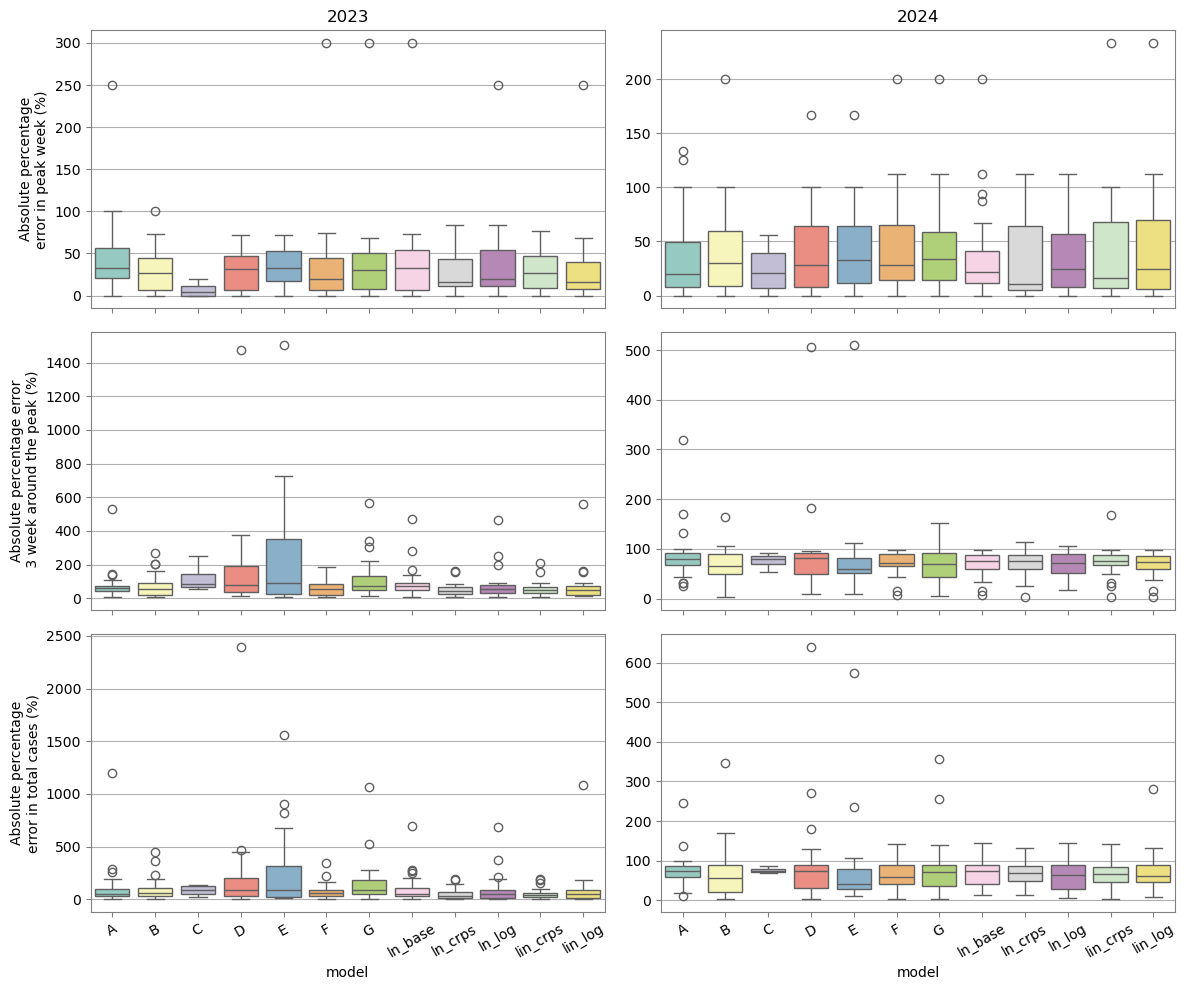

In [15]:
fig, ax = plt.subplots(3, 2, figsize = (12, 10), sharex = True)

sns.boxplot(ax=ax[0,0], x = 'model', y = 'erro_pw',data = df_metrics_23, palette=COLOR_MAP)

sns.boxplot(ax=ax[1,0], x = 'model', y = 'erro_3pw',data = df_metrics_23, palette=COLOR_MAP)

sns.boxplot(ax=ax[2,0], x = 'model', y = 'erro_sum_cases',data = df_metrics_23, palette=COLOR_MAP)

sns.boxplot(ax=ax[0,1], x = 'model', y = 'erro_pw',data = df_metrics_24, palette=COLOR_MAP)

sns.boxplot(ax=ax[1,1], x = 'model', y = 'erro_3pw',data = df_metrics_24, palette=COLOR_MAP)

sns.boxplot(ax=ax[2,1], x = 'model', y = 'erro_sum_cases',data = df_metrics_24, palette=COLOR_MAP)

ax[0,0].set_title(2023)
ax[0,1].set_title(2024)

for ax_ in ax.ravel():

    ax_.grid(axis = 'y')
    ax_.set_ylabel('')

    for label in ax_.get_xticklabels():
            label.set_rotation(30)

ax[0,0].set_ylabel('Absolute percentage\nerror in peak week (%)')
ax[1,0].set_ylabel('Absolute percentage error\n 3 week around the peak (%)')
ax[2,0].set_ylabel('Absolute percentage\nerror in total cases (%)')

plt.tight_layout()
plt.savefig('../figures/summary_metrics.pdf', bbox_inches = 'tight')
plt.show()